# Assignment 2
**Murashko Artem | SD20-01 | ar.murashko@innopolis.university**

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

### Imports

In [1]:
import pandas as pd
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Grayscale
from torch.utils.data import DataLoader, Dataset

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import PIL

# Repeatable experiments
np.random.seed(0)
torch.backends.cudnn.enabled = False
torch.manual_seed(0)

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

**Data**
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

### Loading data

In [2]:
data = pd.read_csv('Task 1.csv')
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


### Preprocessing

#### Feature Encoding

Firstly, let's check for missing values and see the data types.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


As we can see, no values are missed.\
The features are categorical and the target is numerical data type.


Also gender, race/ethnicity, lunch and test preparation course features are nominal variables, i.e they don't have intrinsic ordering. In such cases I prefer to use one hot encoding technique, since it does not build/establish any correlation between variables.

In [4]:
ohe = OneHotEncoder(sparse=False)

nominal_categories = ["gender", "race/ethnicity", "lunch", "test preparation course"]
nominal_categories_encoded = ohe.fit_transform(data.loc[:, nominal_categories])

data_ohe_encoded = pd.DataFrame(nominal_categories_encoded, columns=ohe.get_feature_names_out())

data = pd.concat([data, data_ohe_encoded], axis=1)
data.drop(labels=nominal_categories, axis=1, inplace=True)

Let's see the result:

In [5]:
data.head()

,parental level of education,math score,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,high school,67,67,63,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,some high school,40,59,55,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,some college,59,60,50,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,high school,77,78,68,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,associate's degree,78,73,68,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


Parental level of education feature is the ordinal variable, i.e. it has clear ordering of the categories. For such features I will use ordinal encoding technique, because it will preserve the order of the values. \
Let's see the categories:

In [6]:
set(data["parental level of education"])

{"associate's degree",
 "bachelor's degree",
 'high school',
 "master's degree",
 'some college',
 'some high school'}

We need to specify the order of parental level of education. \
I have googled the order of degrees of study, and it has such order: \
high school < high school < some college < associate's degree < bachelor's degree < master's degree

In [7]:
oe = OrdinalEncoder(categories=[["some high school", "high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]])

ordinal_categories = ["parental level of education"]
ordinal_categories_encoded = oe.fit_transform(data[ordinal_categories])

data_oe_encoded = pd.DataFrame(ordinal_categories_encoded, columns=ordinal_categories)

data.drop(labels=ordinal_categories, axis=1, inplace=True)
data = pd.concat([data, data_oe_encoded], axis=1)

We have encoded all the features. \
Let's see the result:

In [8]:
data.head()

,math score,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none,parental level of education
0,67,67,63,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,40,59,55,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,59,60,50,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0
3,77,78,68,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,78,73,68,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0


### Splitting the data
For evaluating your model, we need 80/20 train test split.\
Let's do this:

In [9]:
target_cols = ['math score', 'reading score', 'writing score']
feature_cols = [
    'gender_female',
    'gender_male',
    'race/ethnicity_group A',
    'race/ethnicity_group B',
    'race/ethnicity_group C',
    'race/ethnicity_group D',
    'race/ethnicity_group E',
    'lunch_free/reduced',
    'lunch_standard',
    'test preparation course_completed',
    'test preparation course_none',
    'parental level of education'
]

X = data[feature_cols]
y = data[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
y_train

,math score,reading score,writing score
29,33,54,51
535,82,87,90
695,68,63,62
557,69,68,62
836,53,70,65
...,...,...,...
106,82,74,73
270,71,72,71
860,98,92,90
435,83,87,83


### ANN 

#### Create Fully Connected Network

In [11]:
class ANN(nn.Module):
    def  __init__(self, input_size, num_classes, hidden1_size=0, hidden2_size=0, isRelu=True):
        # if isRelu = True then activation function is Rectified Liner Unit
        # else Tanh activation function will be used
        
        super(ANN, self).__init__()
        
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        
        if hidden1_size == 0:
            self.output = nn.Linear(input_size, num_classes) 
        elif hidden2_size == 0:
            self.fc1 = nn.Linear(input_size, hidden1_size) 
            self.af1 = nn.ReLU() if isRelu else nn.Tanh()
            self.output = nn.Linear(hidden1_size, num_classes) 
        else:
            self.fc1 = nn.Linear(input_size, hidden1_size) 
            self.af1 = nn.ReLU() if isRelu else nn.Tanh()
            self.fc2 = nn.Linear(hidden1_size, hidden2_size)
            self.af2 = nn.ReLU() if isRelu else nn.Tanh()
            self.output = nn.Linear(hidden2_size, num_classes)
            
    def forward(self, x):   
        out = None
        if self.hidden1_size == 0:
            out = self.output(x)
        elif self.hidden2_size == 0:
            out = self.fc1(x)
            out = self.af1(out)
            out = self.output(out)
        else:
            out = self.fc1(x)
            out = self.af1(out)
            out = self.fc2(out)
            out = self.af2(out)
            out = self.output(out)

        return out 

#### Device setting

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#### Train/Test functions

In [13]:
def train(model, device, features, targets, optimizer, epoch, should_log=False):
    # Train
    model.train()
    
    # data
    features = torch.tensor(features.values, dtype=torch.float32).to(device)
    targets = torch.tensor(targets.values, dtype=torch.float32).to(device)
    
    # forward
    scores = model(features)
    loss = criterion(scores, targets)
    mae_loss = F.l1_loss(scores, targets)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    
    # gradient descent
    optimizer.step()

    if should_log and (epoch % log_interval == 0):
        print(f'Epoch: {epoch}')
        print(f'Train MAE loss: {mae_loss.item():.4f}')
        print(f'Train MSE loss: {loss.item():.4f}')

In [14]:
def test(model, device, features, targets, epoch, should_log=False):
    # Evaluate
    model.eval()
    
    with torch.no_grad():
        # data
        features = torch.tensor(features.values, dtype=torch.float32).to(device)
        targets = torch.tensor(targets.values, dtype=torch.float32).to(device)
        
        # predict
        scores = model(features)
        
        # loss
        mae_loss = F.l1_loss(scores, targets)
        mse_loss = F.mse_loss(scores, targets)

    if should_log and (epoch % log_interval == 0):
        print(f'Test MAE loss: {mae_loss.item():.4f}')
        print(f'Test MSE loss: {mse_loss.item():.4f}\n')
    
    return mse_loss.item()

#### Hyperparameters

In [15]:
input_size = 12 # Input layer size
num_classes = 3 # Output layer size
num_epochs = 32
log_interval = 6

#### Loss 

In [16]:
criterion = nn.MSELoss()

#### Tuning the hyperparameters
(number of layers, number of neurons, activation function, learning rate, momentum, regularization).

In [17]:
momentums = [0.2, 0.4, 0.5]
learning_rates = [0.01, 0.001, 0.0001]

number_of_layers = [0, 1, 2]
number_of_neurons = [x for x in range(6, 37, 4)]

is_sgd_optimizer = [True, False]
is_relu_activation_function = [True, False]

results = {} # {mae_loss : [Parameters]}
for momentum in momentums:
    for is_sgd in is_sgd_optimizer:
        for learning_rate in learning_rates:
            for number_of_layer in number_of_layers:
                for number_of_neuron in number_of_neurons:
                    for is_relu in is_relu_activation_function:
                        # Computing hidden layer sizes
                        hidden1_size = number_of_neuron if (number_of_layer != 0) else 0
                        hidden2_size = number_of_neuron if (number_of_layer == 2) else 0
                        
                        # Model and Otimizer Initing
                        model = ANN(input_size, num_classes, hidden1_size, hidden2_size, is_relu).to(device)
                        
                        optimizer = None
                        if is_sgd:
                            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
                        else:
                            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                            
                        # Training    
                        for epoch in range(1, num_epochs + 1):
                            train(model, device, X_train, y_train, optimizer, epoch)
                        
                        # Testing
                        mse_loss = test(model, device, X_test, y_test, 1)

                        # saving the result
                        results[mse_loss] = [momentum, is_sgd, learning_rate, number_of_layer, number_of_neuron, is_relu]

Lets see the results:

In [18]:
mse, best_parameters = sorted(results.items())[0]
momentum, is_sgd, learning_rate, number_of_layer, number_of_neuron, is_relu = best_parameters
best_parameters

[0.5, True, 0.001, 2, 26, True]

#### Tuned Hyperparameters
As tuning showed to us, the most appropriate paramaters is:

In [19]:
print(f'momentum = {momentum}' if is_sgd else 'No momentum in Adam optimizer')
print(f'learning_rate = {learning_rate}')
print(f'number_of_layers = {number_of_layer}')
print(f'neurons_number = {number_of_neuron}')
print('SGD optimizer' if is_sgd else 'Adam optimizer')
print(f"{'Relu' if is_relu else 'Tanh'} activation function")

momentum = 0.5
learning_rate = 0.001
number_of_layers = 2
neurons_number = 26
SGD optimizer
Relu activation function


#### Model and Optimizer Initing

In [20]:
# Computing hidden layer sizes
hidden1_size = number_of_neuron if (number_of_layer != 0) else 0
hidden2_size = number_of_neuron if (number_of_layer == 2) else 0

# Model and Otimizer Initing
model = ANN(input_size, num_classes, hidden1_size, hidden2_size, is_relu).to(device)

optimizer = None
if is_sgd:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Train Network

In [21]:
for epoch in range(1, num_epochs + 1):
    train(model, device, X_train, y_train, optimizer, epoch, True)
    test(model, device, X_test, y_test, epoch, True)

Epoch: 6
Train MAE loss: 65.7499
Train MSE loss: 4550.6611
Test MAE loss: 64.5734
Test MSE loss: 4408.3682

Epoch: 12
Train MAE loss: 36.3686
Train MSE loss: 1544.3956
Test MAE loss: 29.6223
Test MSE loss: 1102.0302

Epoch: 18
Train MAE loss: 11.3711
Train MSE loss: 195.6442
Test MAE loss: 11.5006
Test MSE loss: 196.9248

Epoch: 24
Train MAE loss: 10.7493
Train MSE loss: 173.0533
Test MAE loss: 10.8774
Test MSE loss: 181.7169

Epoch: 30
Train MAE loss: 10.6285
Train MSE loss: 169.4305
Test MAE loss: 10.8161
Test MSE loss: 179.7795



#### Testing & Result

In [22]:
with torch.no_grad():
    # data
    features = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    targets = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    # predict
    scores = model(features)

    # loss
    mae_loss = F.l1_loss(scores, targets)
    mse_loss = F.mse_loss(scores, targets)
        
print(f'Epoch number = {num_epochs}\n')

print("Parameters:")
print(f' momentum = {momentum}' if is_sgd else ' No momentum in Adam optimizer')
print(f' learning_rate = {learning_rate}')
print(f' number_of_layers = {number_of_layer}')
print(f' neurons_number = {number_of_neuron}')
print(' SGD optimizer' if is_sgd else 'Adam optimizer')
print(f"{' Relu' if is_relu else ' Tanh'} activation function\n")

print("Test data loss:")
print(f' MAE loss: {mae_loss:.4f}')
print(f' MSE loss: {mse_loss:.4f}')

Epoch number = 32

Parameters:
 momentum = 0.5
 learning_rate = 0.001
 number_of_layers = 2
 neurons_number = 26
 SGD optimizer
 Relu activation function

Test data loss:
 MAE loss: 10.8076
 MSE loss: 179.5770


### Questions
1. What preprocessing techniques did you use? Why? \
    **Observation:** The features are categorical and the target is numerical data type.
    
    **Gender, race/ethnicity, lunch and test preparation course features** are nominal variables, i.e they don't have intrinsic ordering. In such cases I prefer to use **one hot encoding** technique, since it does not build/establish any correlation between variables.
    
    **Parental level of education** feature is the ordinal variable, i.e. it has clear ordering of the categories. For such features I will use **ordinal encoding technique**, because it will preserve the order of the values.
    
    *Encoding steps and more detailed explanation you can see in* Feature Encoding *section.* 
    
    
2. Describe the fine-tuning process and how you reached your model architecture.\
    I have tuned number of layers, number of neurons, activation function, learning rate, momentum and regularization. 
    
    I've created an array for each parameter with possible values and bruteforce the parameters values. In each iteration I am evalating MSE on the test data and store MSE with the parameters in the dictionary. After bruteforce I've sorted this dictionary and pick the parameters that gives us the smallest MSE.
    
    Since I one hot encoded most of the features the number of layers has increased. After feature encoding procedure I have 12 feature columns and 3 target columns. Thus, my ANN have 12 neurons in the input layer and 3 neurons in the output layer. The number of hidden layers and number of neurons in it I have select after fine-tuning process described above.

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

**Data**\
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

### Loading Data
**! Initially, you need to unzip the folder with dataset**\
**! I have not test / run using cuda (GPU). It may be warnings / errors.**

#### Preprocessing & Augmentation

In [23]:
trans = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Grayscale(1), 
    transforms.ToTensor()
])

#### Datasets

In [24]:
data_train = torchvision.datasets.ImageFolder(root='triple_mnist/train/', transform=trans)
data_test = torchvision.datasets.ImageFolder(root='triple_mnist/test/', transform=trans)
data_val = torchvision.datasets.ImageFolder(root='triple_mnist/val/', transform=trans)

#### Dataloaders

In [25]:
loader_train = DataLoader(data_train, batch_size=32, shuffle=True)
loader_test = DataLoader(data_test, batch_size=32, shuffle=True)
loader_val = DataLoader(data_val, batch_size=32, shuffle=True)

#### Overview

In [26]:
examples = enumerate(loader_test)
batch_id, (example_data, example_targets) = next(examples)

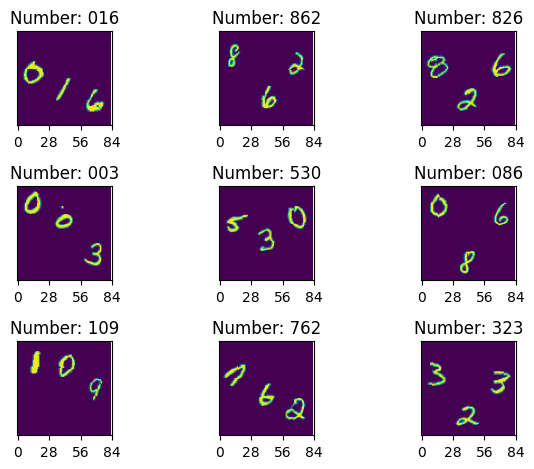

In [27]:
fig = plt.figure()
for i in range(9):
    id = example_targets[i]
    target_number = loader_test.dataset.classes[id]
    img = example_data[i][0]
    
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(img)
    plt.title(f"Number: {target_number}")
    plt.yticks([])
    plt.xticks([x * 28 for x in range(0, 4)])
plt.show()

### Train / Test Functions

In [28]:
# Training on the part of the image
def train_digit(position, device, images, target_numbers, model, criterion, optimizer):
    optimizer.zero_grad()
    
    digit = None
    if position == 0:
        digit = images[:, :, :, :28] # Left rectangle 84x28
    elif position == 1:
        digit = images[:, :, :, 28:28*2] # Middle rectangle 84x28
    else: 
        digit = images[:, :, :, 28*2:] # Right rectangle 84x28
        
    output_digit = model(digit).to(device)
    prediction_digit = output_digit.argmax(dim=1, keepdim=True).reshape(-1)

    target_digit = [int(number[position]) for number in target_numbers]
    target_digit = torch.tensor(target_digit).to(device)
    
    matched_number = sum(a_ == b_ for a_, b_ in zip(prediction_digit, target_digit))
        
    loss = criterion(output_digit, target_digit)
    loss_res = loss.item()
    loss.backward()
    optimizer.step()
    
    return loss_res, matched_number
        
def train(model, device, loader_train, criterion, optimizer, epoch, log_interval=10):
    model.train()
    total_loss = 0
    total_matched = 0
    
    start_time = time()
    for batch_idx, (images, class_ids) in enumerate(loader_train):
        images = images.to(device)
        class_ids = class_ids.to(device)
        
        # Getting batch target labels
        target_numbers = [loader_train.dataset.classes[id] for id in class_ids]

        # First digit
        loss_1, matched_1 = train_digit(0, device, images, target_numbers, model, criterion, optimizer)
        
        # Second digit
        loss_2, matched_2 = train_digit(1, device, images, target_numbers, model, criterion, optimizer)
        
        # Third digit
        loss_3, matched_3 = train_digit(2, device, images, target_numbers, model, criterion, optimizer)
        
        # Results
        total_matched += matched_1 + matched_2 + matched_3
        total_loss += (loss_1 + loss_2 + loss_3) * len(target_numbers)

        if batch_idx % log_interval == 0:
            print(f"\rEpoch = {epoch}", end="")
            print(f" | {batch_idx * len(images)}/{len(loader_train.dataset)}", end="")

    end_time = time()
    
    print(f"\rEpoch = {epoch}")
    print(f"Time = {end_time - start_time:.0f} sec")
    print(f"Train Avg Loss = {total_loss / len(loader_train.dataset):.4f}")
    
    accuracy = 100. * total_matched / (len(loader_train.dataset) * 3)
    return accuracy, end_time - start_time

In [29]:
# Testing on the part of the image
def test_digit(position, device, images, target_numbers, model, criterion):
    digit = None
    if position == 0:
        digit = images[:, :, :, :28] # Left rectangle 84x28
    elif position == 1:
        digit = images[:, :, :, 28:28*2] # Middle rectangle 84x28
    else: 
        digit = images[:, :, :, 28*2:] # Right rectangle 84x28
        
    output_digit = model(digit).to(device)
    prediction_digit = output_digit.argmax(dim=1, keepdim=True).reshape(-1)

    target_digit = [int(number[position]) for number in target_numbers]
    target_digit = torch.tensor(target_digit).to(device)
    
    matched_number = sum(a_ == b_ for a_, b_ in zip(prediction_digit, target_digit))
        
    loss = criterion(output_digit, target_digit)
    loss_res = loss.item()
    
    return loss_res, matched_number

def test(model, device, loader_test, criterion, is_val_loader):
    model.eval()
    
    total_loss = 0
    total_matched = 0
    
    start_time = time()
    with torch.no_grad():
        for images, class_ids in loader_test:
            images = images.to(device)
            class_ids = class_ids.to(device)
            
            # Getting batch target labels
            target_numbers = [loader_test.dataset.classes[id] for id in class_ids]
            
            # First digit
            loss_1, matched_1 = test_digit(0, device, images, target_numbers, model, criterion)

            # Second digit
            loss_2, matched_2 = test_digit(1, device, images, target_numbers, model, criterion)

            # Third digit
            loss_3, matched_3 = test_digit(2, device, images, target_numbers, model, criterion)

            # Results
            total_matched += matched_1 + matched_2 + matched_3
            total_loss += (loss_1 + loss_2 + loss_3) * len(target_numbers)

        accuracy = 100. * total_matched / (len(loader_test.dataset) * 3)
        
        print(f"\r{'Val' if is_val_loader else 'Test'} Avg Loss = {total_loss / len(loader_test.dataset):.4f}")
        
    end_time = time()
    return accuracy, end_time - start_time

### ANN from Task 1

#### Adapted ANN

In [30]:
class AdaptedANN(nn.Module):
    def  __init__(self, input_size, num_classes, hidden_size=0):
        super(AdaptedANN, self).__init__()
        self.hidden_size = hidden_size
        
        if hidden_size == 0:
            self.output = nn.Linear(input_size, num_classes)
        else:
            self.fc1 = nn.Linear(input_size, hidden_size) 
            self.af1 = nn.ReLU() 
            self.output = nn.Linear(hidden_size, num_classes)
            
    def forward(self, x):
        x = x.reshape(-1, 84 * 84 // 3)
        
        if self.hidden_size == 0:
            out = self.output(x)
        else:
            out = self.fc1(x)
            out = self.af1(out)
            out = self.output(out)
        return nn.functional.log_softmax(out, dim=1)

#### Device setting

In [31]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#### Hyperparameters

In [32]:
input_size = 84 * 28 # Input layer size
num_classes = 10 # Output layer size
num_epochs = 5
momentum = 0.5
learning_rate = 0.01

#### Model Initing

In [33]:
model_task1 = AdaptedANN(input_size, num_classes).to(device)

#### Optimizer & Criterion

In [34]:
criterion_task1 = nn.CrossEntropyLoss()
optimizer_task1 = optim.SGD(model_task1.parameters(), lr=learning_rate, momentum=momentum)

#### Training

In [35]:
for epoch in range(1, num_epochs + 1):
    train_acc, time_train = train(model_task1, device, loader_train, criterion_task1, optimizer_task1, epoch)
    print(f"Train Accuracy = {train_acc:.2f}%")
    
    val_acc, time_test_val = test(model_task1, device, loader_val, criterion_task1, is_val_loader=True)
    print(f"Val Accuracy = {val_acc:.2f}%\n")

Epoch = 1 | 63680/64000
Time = 74 sec
Train Avg Loss = 5.5529
Train Accuracy = 36.38%
Val Avg Loss = 5.2829
Val Accuracy = 39.83%

Epoch = 2 | 63680/64000
Time = 68 sec
Train Avg Loss = 5.2403
Train Accuracy = 40.15%
Val Avg Loss = 5.1833
Val Accuracy = 41.01%

Epoch = 3 | 63680/64000
Time = 67 sec
Train Avg Loss = 5.1741
Train Accuracy = 40.90%
Val Avg Loss = 5.1444
Val Accuracy = 41.26%

Epoch = 4 | 63680/64000
Time = 80 sec
Train Avg Loss = 5.1410
Train Accuracy = 41.09%
Val Avg Loss = 5.1121
Val Accuracy = 41.83%

Epoch = 5 | 63680/64000
Time = 74 sec
Train Avg Loss = 5.1220
Train Accuracy = 41.32%
Val Avg Loss = 5.0875
Val Accuracy = 42.17%



#### Testing

In [36]:
test_acc_ann, time_test_ann = test(model_task1, device, loader_test, criterion_task1, is_val_loader=False)
print(f"Test Accuracy = {test_acc_ann:.2f}%")

Test Avg Loss = 5.1117
Test Accuracy = 41.63%


### CNN

#### Create  Convolutional Neural Network

In [83]:
# Get idea of the model from https://www.youtube.com/watch?v=wnK3uWv_WkU
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=8, 
                               kernel_size=5, 
                               padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, 
                               out_channels=16, 
                               kernel_size=5, 
                               padding=2)
        self.fc1 = nn.Linear(7 * 7 * 48, 128)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return F.log_softmax(x, dim=1)

#### Hyperparameters

In [43]:
num_epochs = 5
learning_rate = 0.01
momentum = 0.5

#### Model Initing

In [44]:
model = CNN()

#### Optimizer & Criterion

In [45]:
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate,
                      momentum=momentum)
criterion = nn.CrossEntropyLoss()

#### Training

In [46]:
for epoch in range(1, num_epochs + 1):
    train_acc, time_train = train(model, device, loader_train, criterion, optimizer, epoch)
    print(f"Train Accuracy: {train_acc:.2f}%")
    
    val_acc, time_test_val = test(model, device, loader_val, criterion, is_val_loader=True)
    print(f"Validation Accuracy: {val_acc:.2f}%\n")

Epoch = 1 | 63680/64000
Time = 117 sec
Train Avg Loss = 2.1547
Train Accuracy: 75.10%
Val Avg Loss = 0.5832
Validation Accuracy: 94.00%

Epoch = 2 | 63680/64000
Time = 113 sec
Train Avg Loss = 0.4539
Train Accuracy: 95.29%
Val Avg Loss = 0.3873
Validation Accuracy: 95.90%

Epoch = 3 | 63680/64000
Time = 109 sec
Train Avg Loss = 0.3104
Train Accuracy: 96.79%
Val Avg Loss = 0.2922
Validation Accuracy: 96.88%

Epoch = 4 | 63680/64000
Time = 114 sec
Train Avg Loss = 0.2456
Train Accuracy: 97.44%
Val Avg Loss = 0.2643
Validation Accuracy: 97.30%

Epoch = 5 | 63680/64000
Time = 94 sec
Train Avg Loss = 0.2041
Train Accuracy: 97.84%
Val Avg Loss = 0.2266
Validation Accuracy: 97.68%



#### Testing

In [47]:
test_acc_cnn, time_test_cnn = test(model, device, loader_test, criterion, is_val_loader=False)
print(f"Test Accuracy: {test_acc_cnn:.2f}%")

Test Avg Loss = 0.2277
Test Accuracy: 97.68%


### Models Comparing

In [60]:
print(f"Accuracy of the model from task 1 on the test data is {test_acc_ann / 100:.4f}")
print(f"Accuracy of the CNN on the test data is {test_acc_cnn / 100:.4f}")

Accuracy of the model from task 1 on the test data is 0.4163
Accuracy of the CNN on the test data is 0.9768


As we can see, CNN model has performed much better.

In [62]:
print(f"Tesing time of the model from task 1 is {time_test_ann:.1f} seconds")
print(f"Tesing time of CNN model is {time_test_cnn:.1f} seconds")

Tesing time of the model from task 1 is 24.8 seconds
Tesing time of CNN model is 27.2 seconds


ANN model from task1 tests faster. But we can notice a big difference in the train time: CNN trains twice as long as ANN (from task1).

### Questions
**General Idea:**
I divided each picture into three parts and trained the model on each of them.
The reason why I did this is that the pattern of positioning of numbers on the data is always the same. Each number is in its part horizontally. That is, the task comes down to what we have already done on the labs.
The initial picture is 84x84, thus one part will be 84x28. So, I have 2352 input neurons. The ouput is 10 neurons, the same as we have done in the lab. 
Generally, to predict three digit number I need to split the picture into three parts. Then predict the digit on each part and concatenate them to get the whole number.

1. What preprocessing techniques did you use? Why?
    - Firstly, I have grayscaled each image since they are RGB by default. 
    - Secondly, I have transformed each image into tensor. Because it is easier to work with data in the form of tensors.
2. What data augmentation techniques did you use?
    - I have used random rotation of the data as augmentation technique. I think it is good to do that because not all the digits are strictly verical. 
3. Describe the fine-tuning process and how you reached your final CNN model.
    - I have done all the work on my CPU, so it was problematic to perform the best fine-tuning. But I have tried different optimizers, SGD was the best one for adapted ANN from task1 and for CNN. Also I have fine-tune epoch number, 5 is the most appropriate. Hyperparameters like momentum or learning rate I have taken default ones (i.e. 0.5 and 0.01).

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

***Data***
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

### Loading Data

In [63]:
data = pd.read_csv('loan_data.csv')
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


### Preprocessing

#### Data encoding

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [65]:
ohe = OneHotEncoder(sparse=False)

categories = ["purpose"]
categories_encoded = ohe.fit_transform(data.loc[:, categories])

data_ohe_encoded = pd.DataFrame(categories_encoded, columns=ohe.get_feature_names_out())

data = pd.concat([data, data_ohe_encoded], axis=1)
data.drop(labels=categories, axis=1, inplace=True)

#### Data standartization

**This step can be skipped. DT requires little data preparation, it does not necessary to standartize the data.**

In [66]:
scaler = StandardScaler()
features_to_scale = [
    'int.rate',
    'installment',
    'log.annual.inc',
    'dti',
    'fico',
    'days.with.cr.line',
    'revol.bal',
    'revol.util',
    'inq.last.6mths',
    'delinq.2yrs',
    'pub.rec'
]

data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

#### Data after preprocessing

In [67]:
data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,-0.139318,2.463099,0.680388,0.998505,0.688825,0.432230,0.353732,0.182704,-0.716989,-0.299730,-0.237003,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,-0.578868,-0.438854,0.244031,0.244540,-0.101303,-0.721230,0.495018,1.030602,-0.716989,-0.299730,-0.237003,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0.486484,0.230708,-0.908659,-0.141885,-0.759742,0.059770,-0.397073,-0.730683,-0.262470,-0.299730,-0.237003,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,-0.813544,-0.757022,0.680388,-0.654697,0.030385,-0.745277,0.496321,0.909966,-0.262470,-0.299730,-0.237003,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0.743509,-1.043992,0.597961,0.343326,-1.154806,-0.198161,-0.360663,-0.251586,-0.716989,1.531147,-0.237003,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Splitting the data
For evaluating the model we need 80/20 train test split.\
Let's do this:

In [68]:
target_cols = ['credit.policy']
feature_cols = [
    'int.rate',
    'installment',
    'log.annual.inc',
    'dti',
    'fico',
    'days.with.cr.line',
    'revol.bal',
    'revol.util',
    'inq.last.6mths',
    'delinq.2yrs',
    'pub.rec',
    'not.fully.paid',
    'purpose_all_other',
    'purpose_credit_card',
    'purpose_debt_consolidation',
    'purpose_educational',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_small_business'
]

X = data[feature_cols]
y = data[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.head()

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
8558,1.186785,0.649233,-0.545694,0.277953,-1.418182,-0.300692,-0.247937,1.220173,0.646567,-0.299730,-0.237003,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4629,-0.161668,1.035304,0.364575,-0.249386,0.557137,-0.384799,-0.028795,-0.203331,0.646567,-0.299730,-0.237003,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1383,-0.299493,-0.586009,-0.949841,0.163188,-0.496366,-0.997600,-0.081766,1.344256,-0.716989,-0.299730,-0.237003,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8142,1.563011,-1.028344,0.113834,2.259472,-1.023118,0.768694,-0.268645,-0.723790,1.101085,1.531147,-0.237003,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1768,-0.020117,-0.768710,0.317519,-1.251767,-0.232991,0.191939,-0.487224,-1.364884,-0.262470,1.531147,-0.237003,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Decision Tree

#### Fine Tuning
#### Bruteforce approach

In [69]:
dt_max_depths = [x for x in range(1, 21)]
dt_results = {} # {accuracy : depth}

for dt_max_depth in dt_max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=dt_max_depth, random_state=42)
    dt_clf.fit(X_train, y_train)

    dt_score = dt_clf.score(X_test,y_test)
    dt_results[dt_score] = dt_max_depth
#     print(f'Validation accuracy for max_depth = {dt_max_depth} is {dt_score:.4f}')

#### Results

In [70]:
dt_best_accuracy, dt_max_depth = sorted(dt_results.items())[-1]
print(f"The best accuracy in df is {dt_best_accuracy:.4f} with max depth = {dt_max_depth}")

The best accuracy in df is 0.9932 with max depth = 20


#### GridSearchCV approach

In [71]:
dt_param_grid = {
    'max_depth': [x for x in range(1, 21)],
    'criterion': ['gini', 'entropy']
}

dt_clf = DecisionTreeClassifier(random_state=42)

dt_grid_search = GridSearchCV(estimator=dt_clf, 
                              param_grid=dt_param_grid, 
                              cv=5, verbose=True)

dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             verbose=True)

In [72]:
dt_best_grid = dt_grid_search.best_estimator_
dt_best_grid

DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=42)

#### Results

In [74]:
dt_best_grid_score = dt_best_grid.score(X_test, y_test)
print(f"The best accuracy in df is {dt_best_grid_score:.4f} with max depth = {dt_best_grid.max_depth}")

The best accuracy in df is 0.9916 with max depth = 11


### Random Forest

#### Fine Tuning
#### Bruteforce approach

In [75]:
rf_max_depths = [x for x in range(1, 21)]
rf_results = {} # {accuracy : depth}

for rf_max_depth in rf_max_depths:
    rf_clf = RandomForestClassifier(max_depth=rf_max_depth, random_state=42)
    rf_clf.fit(X_train, y_train.values.ravel()) # .values.ravel() to remove warnings

    rf_score = rf_clf.score(X_test,y_test)
    rf_results[rf_score] = rf_max_depth
#     print(f'Validation accuracy for max_depth = {rf_max_depth} is {rf_score:.4f}')

#### Results

In [76]:
rf_best_accuracy, rf_max_depth = sorted(rf_results.items())[-1]
print(f"The best accuracy in rf is {rf_best_accuracy:.4f} with max depth = {rf_max_depth}")

The best accuracy in rf is 0.9870 with max depth = 13


#### GridSearchCV approach

In [77]:
rf_param_grid = {
    'max_depth': [x for x in range(12, 21)],
    'criterion': ['gini', 'entropy']
}

rf_clf = RandomForestClassifier(random_state=42)

rf_grid_search = GridSearchCV(estimator=rf_clf, 
                              param_grid=rf_param_grid, 
                              cv=5, verbose=True)

rf_grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [12, 13, 14, 15, 16, 17, 18, 19, 20]},
             verbose=True)

In [78]:
rf_best_grid = rf_grid_search.best_estimator_
rf_best_grid

RandomForestClassifier(max_depth=18, random_state=42)

#### Results

In [79]:
rf_best_grid_score = rf_best_grid.score(X_test, y_test)
print(f"The best accuracy in rf is {rf_best_grid_score:.4f} with max depth = {rf_best_grid.max_depth}")

The best accuracy in rf is 0.9859 with max depth = 18


### Performance comparison

- *Decision Tree*
    - Bruteforce approach: Iterating over max_depth of the tree showed **0.993 accurracy** with **20 max depth**. 
    - GridSearchCV approach: Here I have tested max_depth and gini/entropy criterion using grid search. The results is **0.991 accurracy** with **11 max depth**.
        - Greedy search is as fast as iteration
- *Random Forest*
    - Bruteforce approach: Iterating over max_depth of the tree showed **0.987 accurracy** with **13 max depth**. 
    - GridSearchCV approach: Here I have tested max_depth and gini/entropy criterion using grid search. The results is **0.985 accurracy** with **18 max depth**.
        - Greedy search is much slower than iteration
        
As we can see, the accuracy are approximately the same. But DT accuracy is 1% better. It also learns much faster than RF.

### Plotting

In [80]:
import graphviz
def plot_tree(clf):
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=feature_cols,
                       class_names=['1', '0'],
                       filled=True, rounded=True,
                       special_characters=True)
    
    graph = graphviz.Source(dot_data)
    return graph

#### Decision Tree

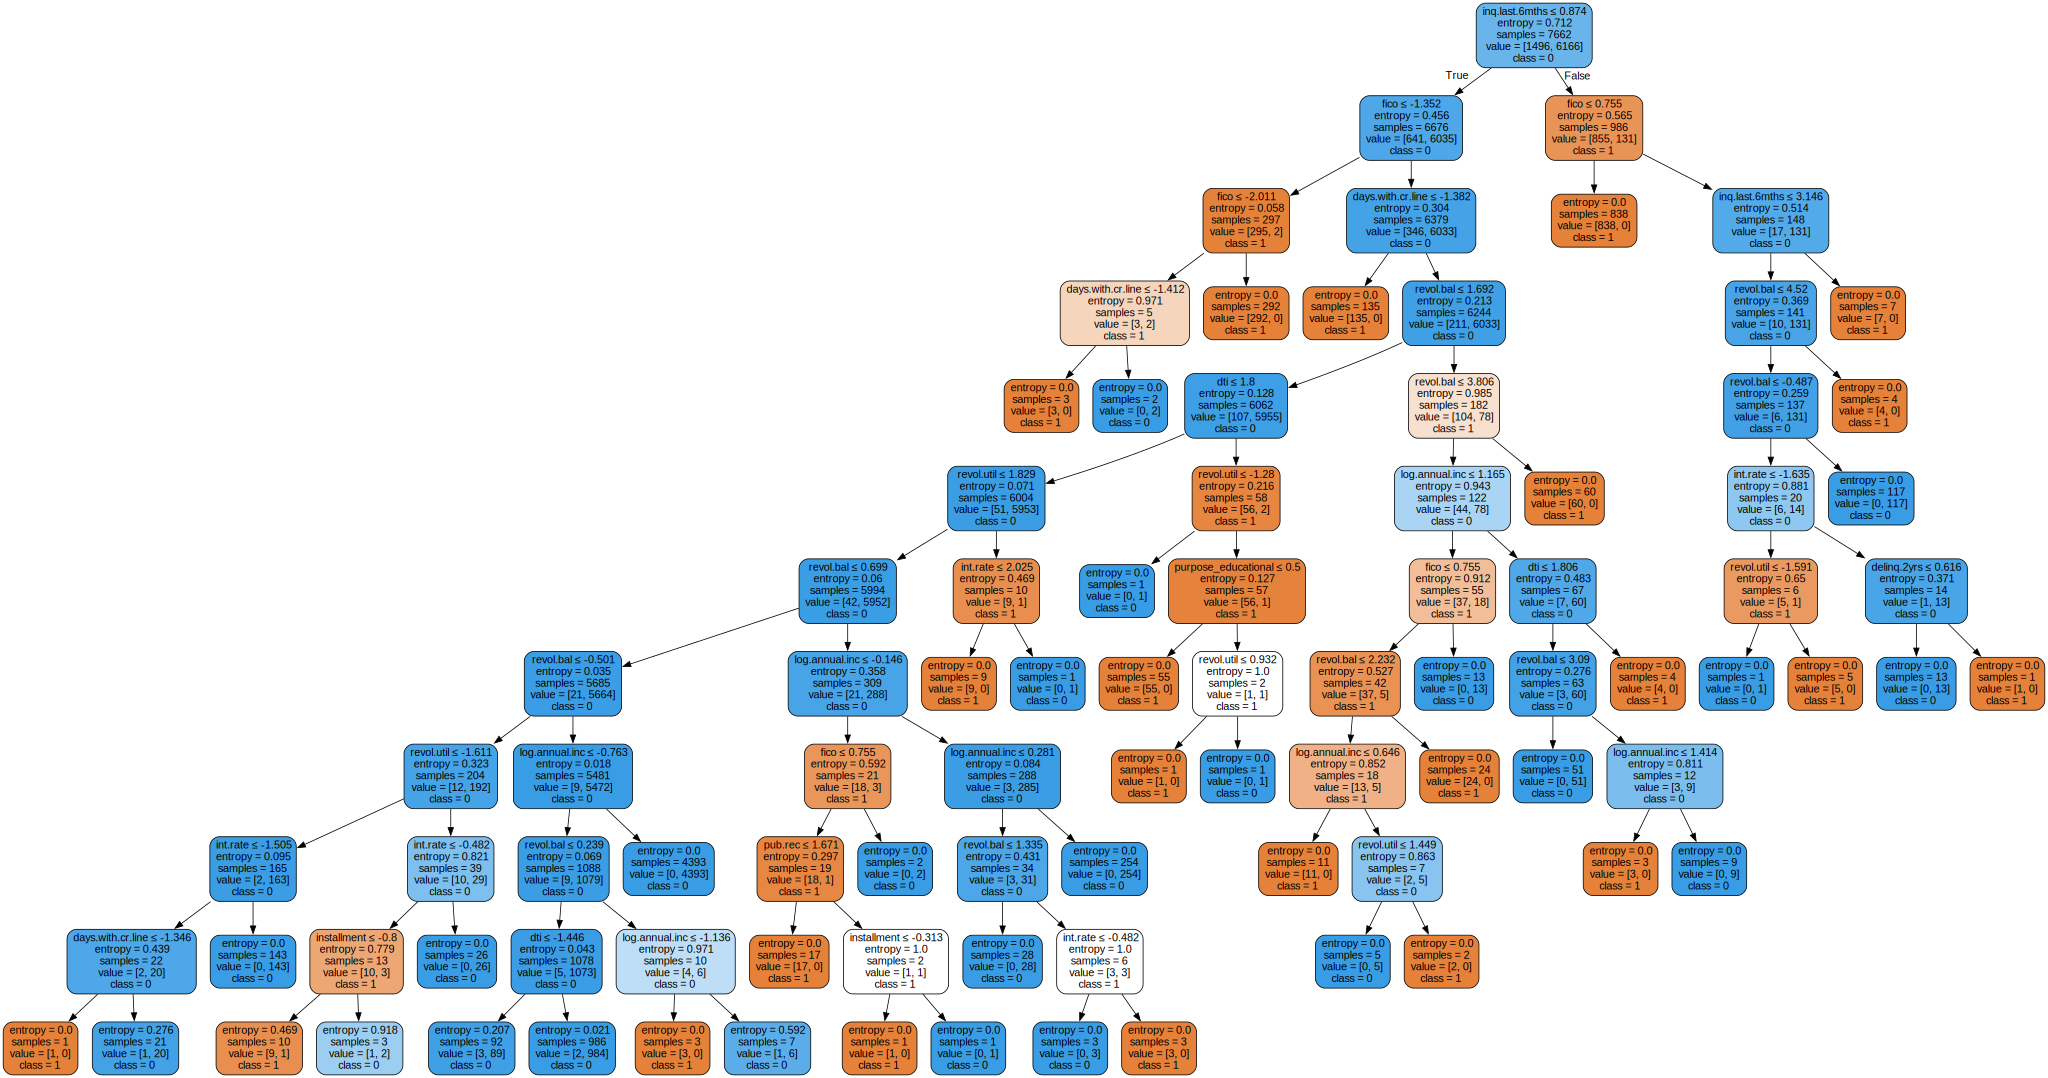

In [81]:
dt_graph = plot_tree(dt_best_grid)
dt_graph

#### Random Forest

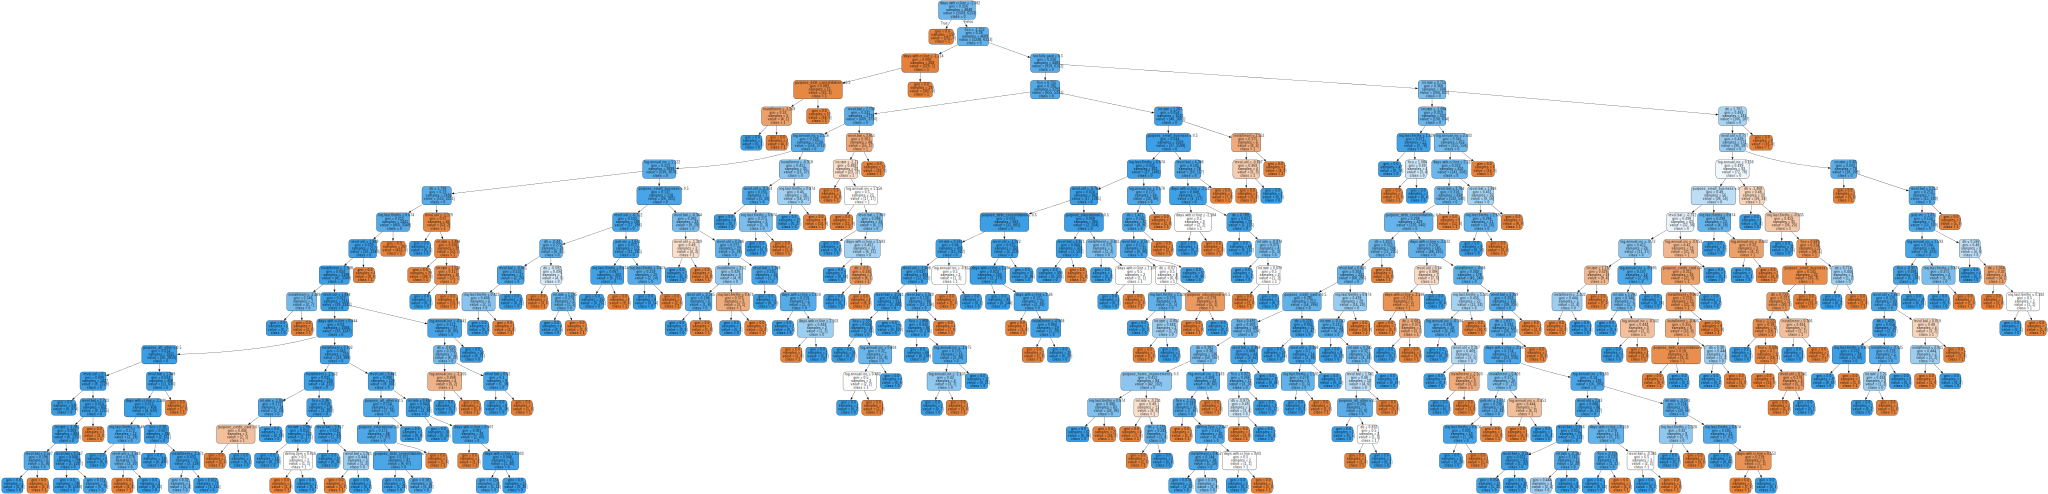

In [82]:
# Extract single tree
single_tree = rf_best_grid.estimators_[0]

# Plotting
dt_graph = plot_tree(single_tree)
dt_graph

### Questions

**Observations:** It will be better to 70/30 train test split, since 80% of the applicants meet the criteria of the credit policy. Otherwise it may occur that all the applicants in our train data will meet the criteria.

1. How did the DT compare to the RF in performance? Why?\
    The accuracy are approximately the same - 99%, because the data is easy to classify.\
    The results of RF is a little bit lower and it works slower because RF avoids and prevents overfitting by using multiple trees.
    
    
2. After fine-tuning, how does the max depth in DT compare to RF? Why?\
    Grid search evaluates max depth = 11 for DT and 18 for RF.\
    RF needs more depth than DT because it is allowed for each tree inside RF to overfit. 


3. What is ensemble learning? What are its pros and cons?\
    **Ensemble learning** is a meta-learning algorithms that combine several ML models into one predictive model *(from lectures)*.\
    **Pros**: Combining the power of multiple models in a single model via overcoming their weaknesses, we reducing the model's variance and/or bias.\
    **Cons**: The output of the ensembled model is hard to predict. Usually, ensemble learning is computationaly expensive. 
    
    
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods. Which of these categories does RF fall under?
    - **Boosting methods:**
        - Adative Boosting - is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. *(scikit-learn.org)*
        - Gradient Boosting - builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage  regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced. *(scikit-learn.org)*
        
    - **Bagging methods:**
        -  Random Forest - is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. *(scikit-learn.org)*
        - 

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [87]:
# trans = transforms.Compose([transforms.Grayscale(1), 
#                             transforms.ToTensor()])
# svhn_data = torchvision.datasets.ImageFolder(root='svhn/', transform=trans)

## Questions
1. How did your model perform? Why is it better/worse?
    - The model will perform worse since I just crop the image into three parts. It can occur that there will be part without any digit. Here should be used some other techniques, like rectangle with nubmer recognition or etc.
2. What is domain gap in the context of ML?
    - Domain gap problem - models that are trained on simulated data (e.g. concatenated MNIST dataset) cannot perform well on practical data (current SVHN dataset).
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*